In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image, ImageDraw

# Updated Dataset Class
class CircleDataset(Dataset):
    def __init__(self, num_samples=1, img_size=128):
        self.num_samples = num_samples
        self.img_size = img_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img = Image.new('L', (self.img_size, self.img_size), 0)
        draw = ImageDraw.Draw(img)

        # Randomly generate two circles
        for _ in range(2):
            x, y = np.random.randint(10, self.img_size - 10, 2)
            r = np.random.randint(5, 15)
            draw.ellipse((x - r, y - r, x + r, y + r), fill=255)

        img_array = np.array(img) / 255.0  # Normalize
        img_tensor = torch.tensor(img_array, dtype=torch.float32).unsqueeze(0)
        
        #plt.figure()
        #plt.imshow(img_array)
        #plt.axis("off")

        # Generate instance masks
        masks = []
        for mm in range(2):
            
            mask = Image.new('L', (self.img_size, self.img_size), 0)
            draw = ImageDraw.Draw(mask)
            
            #mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
            x, y = np.random.randint(10, self.img_size - 10, 2)
            r = np.random.randint(5, 15)
            draw = ImageDraw.Draw(Image.fromarray(mask))
            draw.ellipse((x - r, y - r, x + r, y + r), fill=255)
            
            mask = np.array(mask) / 255.0  # Normalize
            
            masks.append(mask)
            
            print('hello')
            
            plt.figure()
            plt.imshow(mask)
            plt.title("mask"+str(mm))
            plt.axis("off")
            

        masks = np.stack(masks)  # Convert list to a single array
        masks_tensor = torch.tensor(masks, dtype=torch.float32)
        return img_tensor, masks_tensor

# Updated Transformer Model with Correct Output Channels
class TransformerSegmentation(nn.Module):
    def __init__(self, img_size=128, patch_size=16, d_model=128, n_heads=4, num_layers=2, num_classes=2):
        super().__init__()
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.num_patches = (img_size // patch_size) ** 2  # Total number of patches

        # Patch embedding
        self.patch_embed = nn.Conv2d(1, d_model, kernel_size=patch_size, stride=patch_size)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Final linear layers to output num_classes per patch
        self.decoder = nn.Linear(d_model, num_classes)

        self.upsample = nn.Upsample(size=(img_size, img_size), mode='bilinear', align_corners=True)

    def forward(self, x):
        batch_size = x.shape[0]

        # Patch embedding
        patches = self.patch_embed(x)  # Shape: (batch_size, d_model, H/patch_size, W/patch_size)
        patches = patches.flatten(2).permute(2, 0, 1)  # Shape: (seq_len, batch_size, d_model)

        # Transformer encoding
        encoded = self.transformer(patches)  # Shape: (seq_len, batch_size, d_model)

        # Decode: Per patch, predict num_classes
        decoded = self.decoder(encoded)  # Shape: (seq_len, batch_size, num_classes)
        decoded = decoded.permute(1, 2, 0)  # Shape: (batch_size, num_classes, seq_len)

        # Reshape decoded output to match the patch grid
        grid_size = int(self.num_patches ** 0.5)  # Number of patches along one dimension
        decoded = decoded.view(batch_size, self.num_classes, grid_size, grid_size)  # Shape: (batch_size, num_classes, grid_size, grid_size)

        # Upsample to full resolution
        upsampled = self.upsample(decoded)  # Shape: (batch_size, num_classes, img_size, img_size)
        return upsampled

# Instantiate the dataset and model
dataset = CircleDataset()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
model = TransformerSegmentation(num_classes=2)  # We need 2 output channels for 2 circles

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for i, (images, masks) in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        
        #print('outputs')
        #print(outputs.shape)

        # Compute loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Step {i}, Loss: {loss.item():.4f}")


TypeError: expected string or buffer

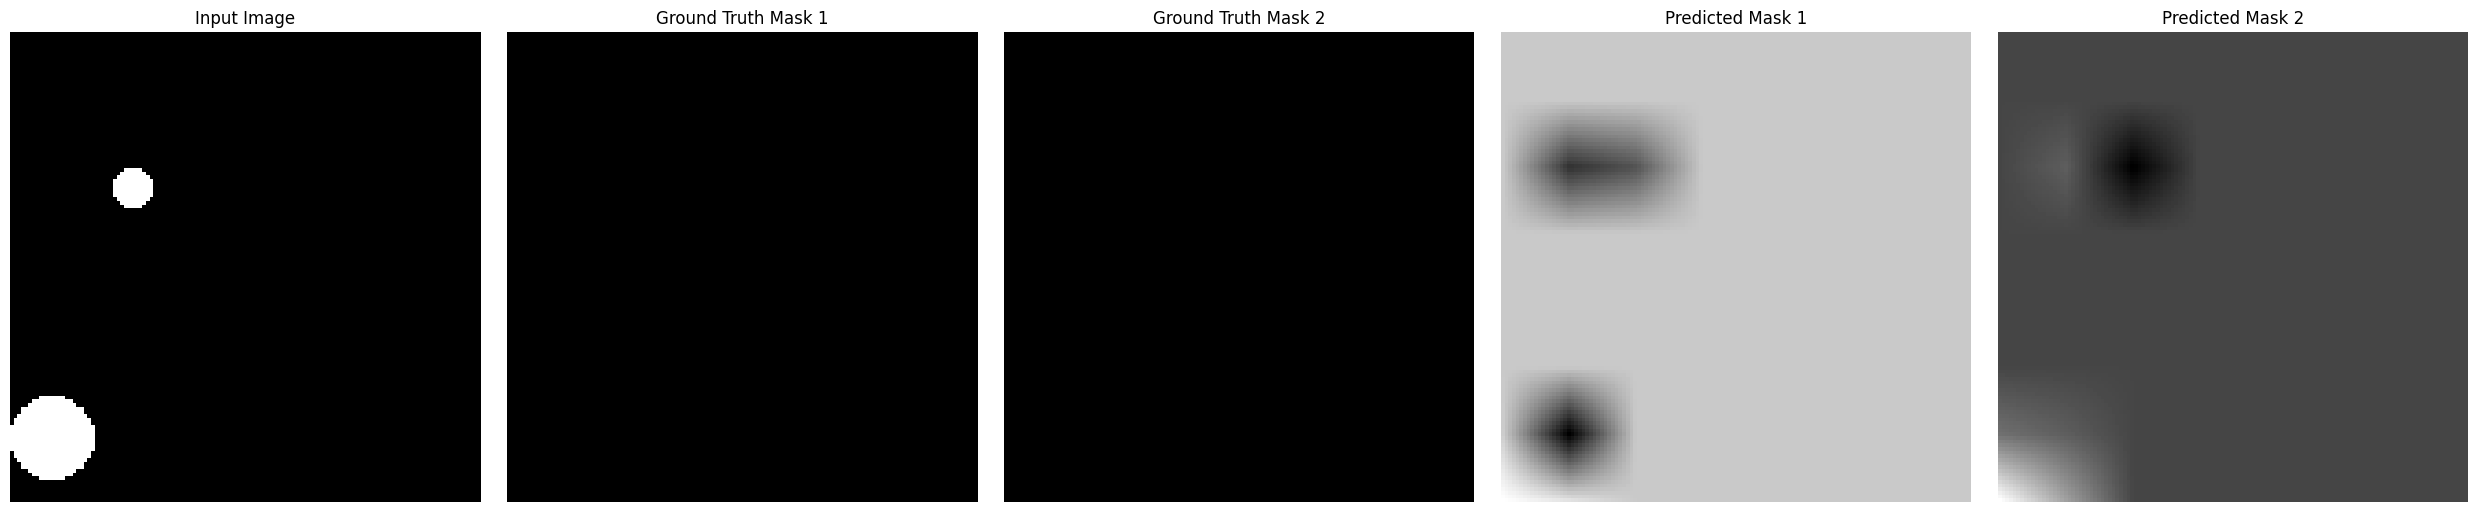

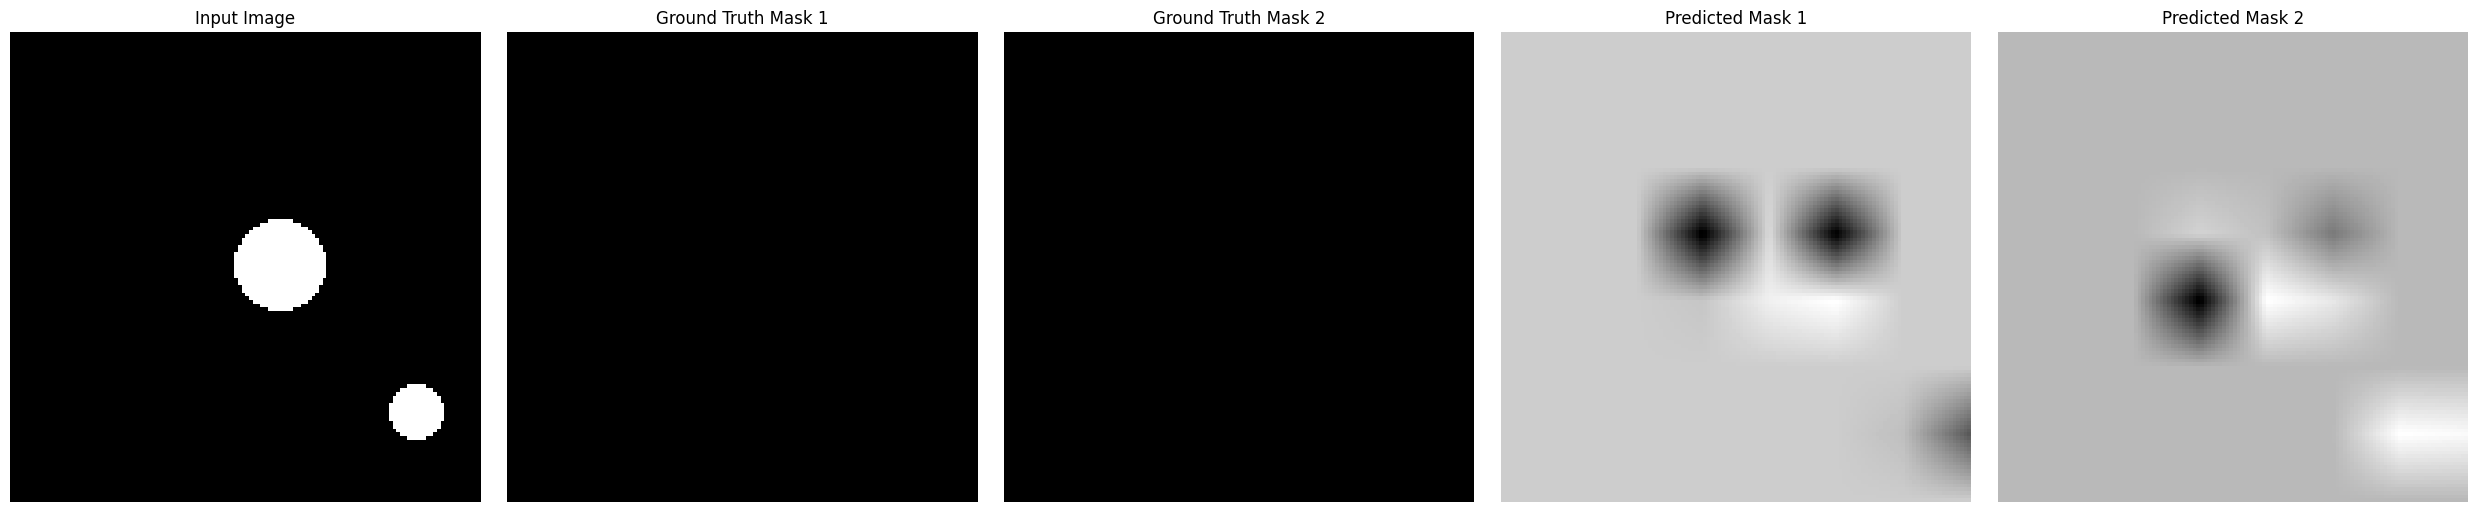

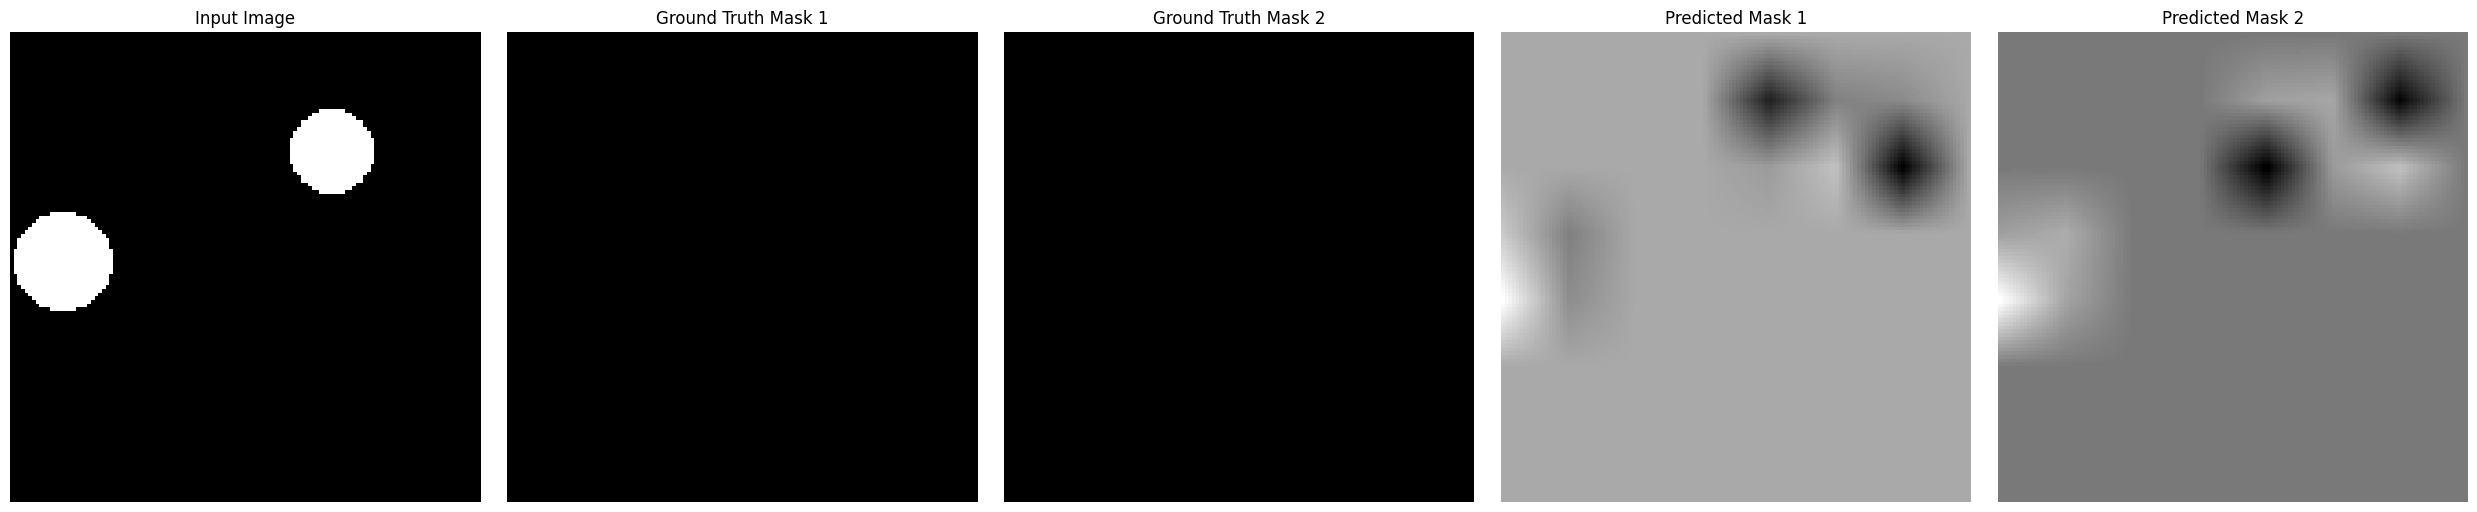

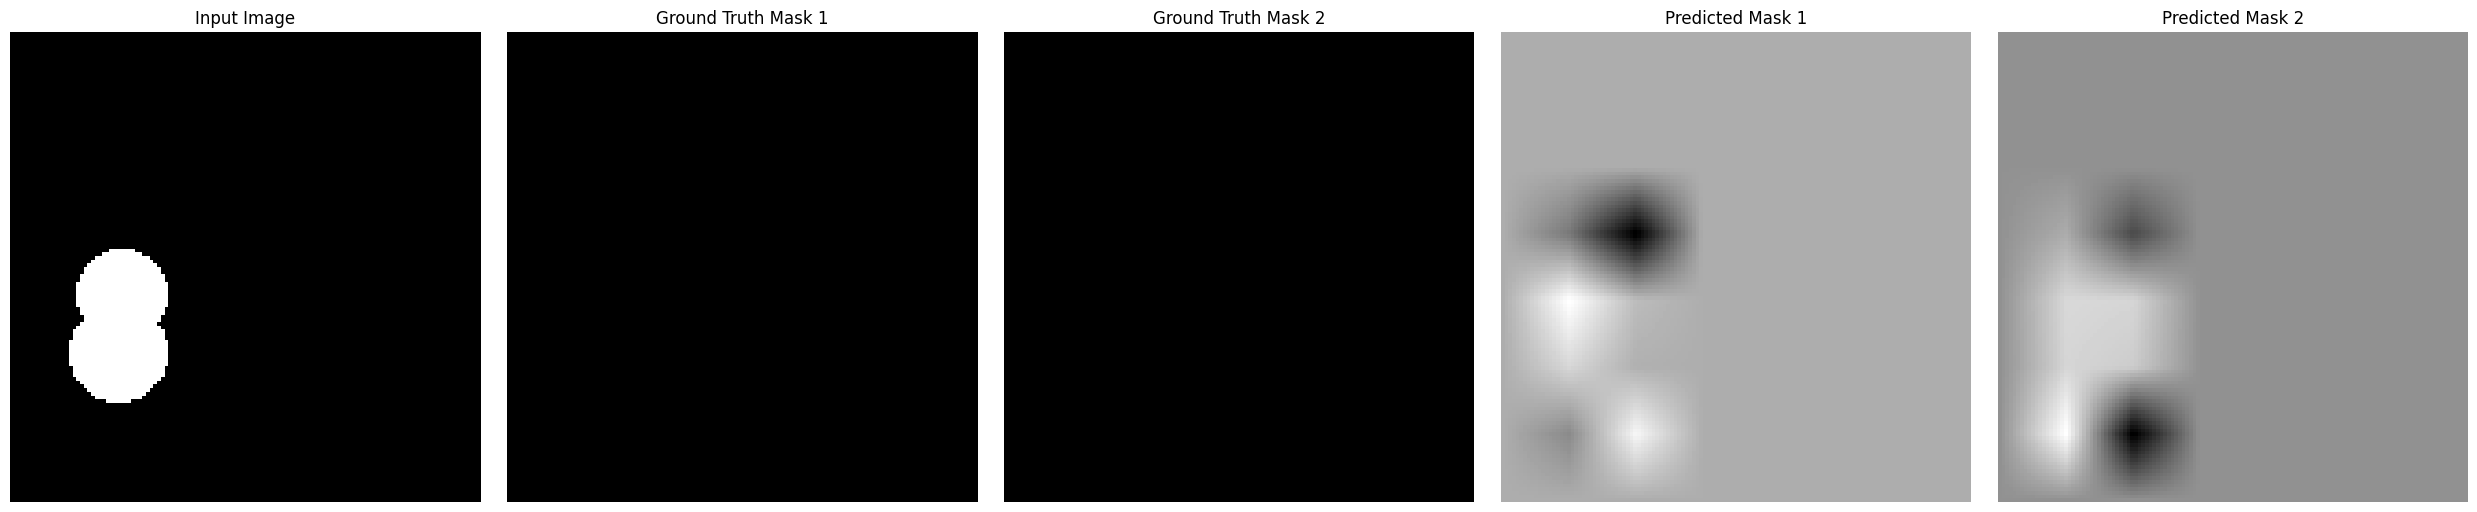

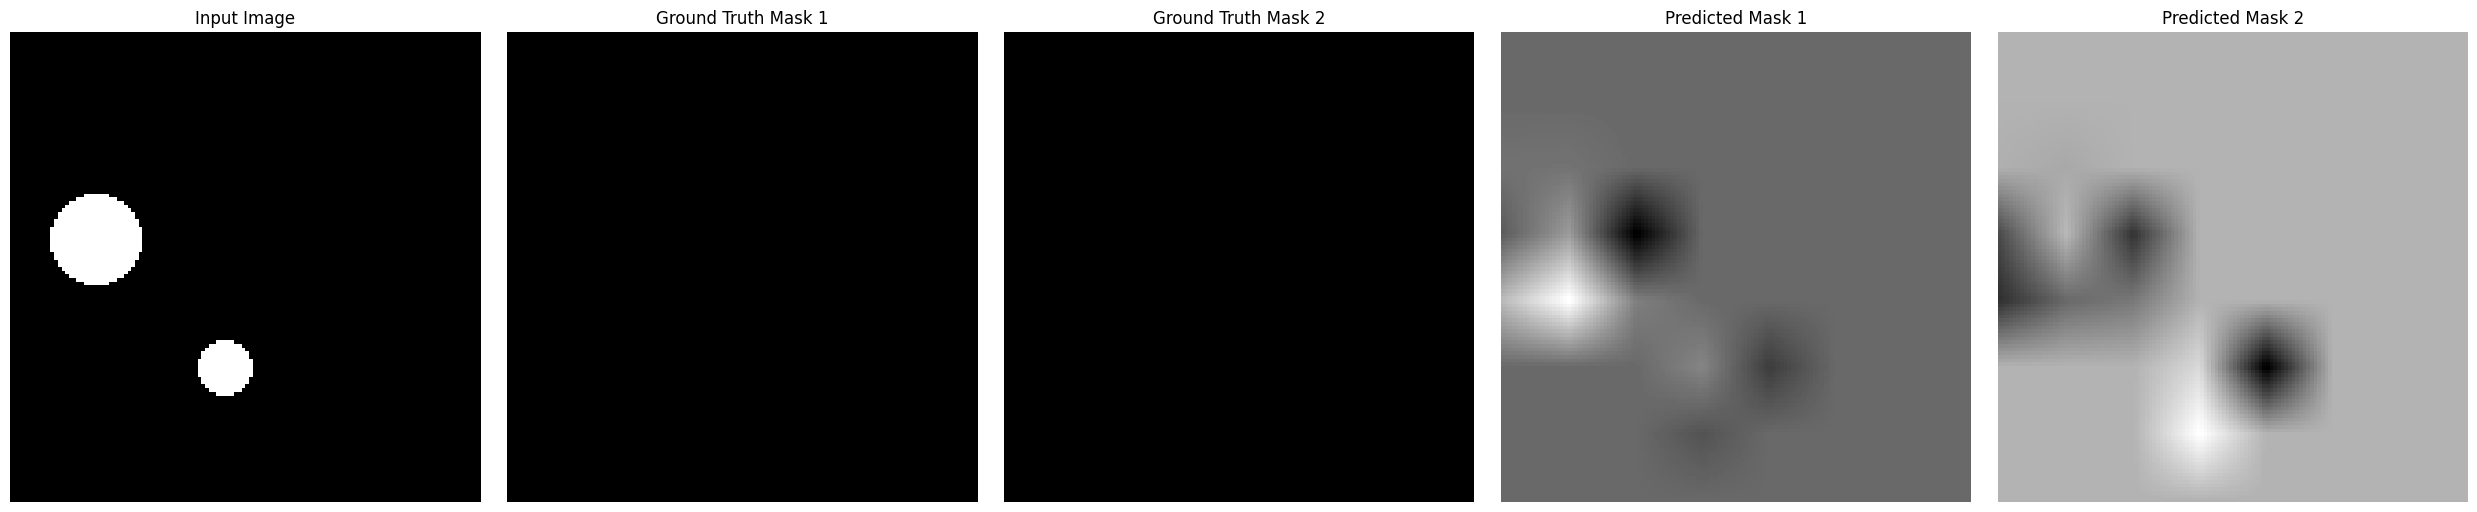

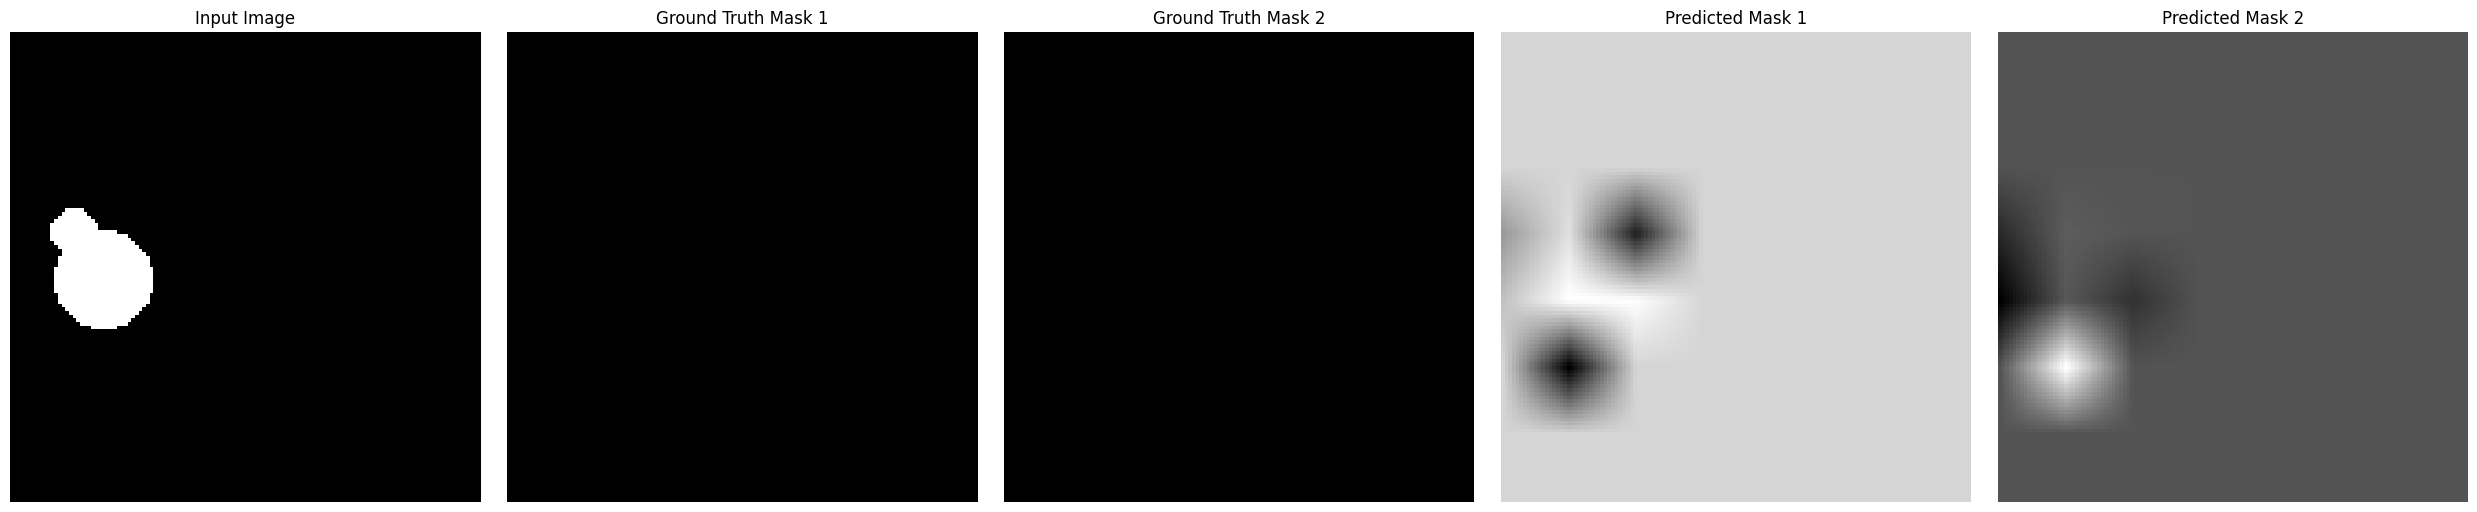

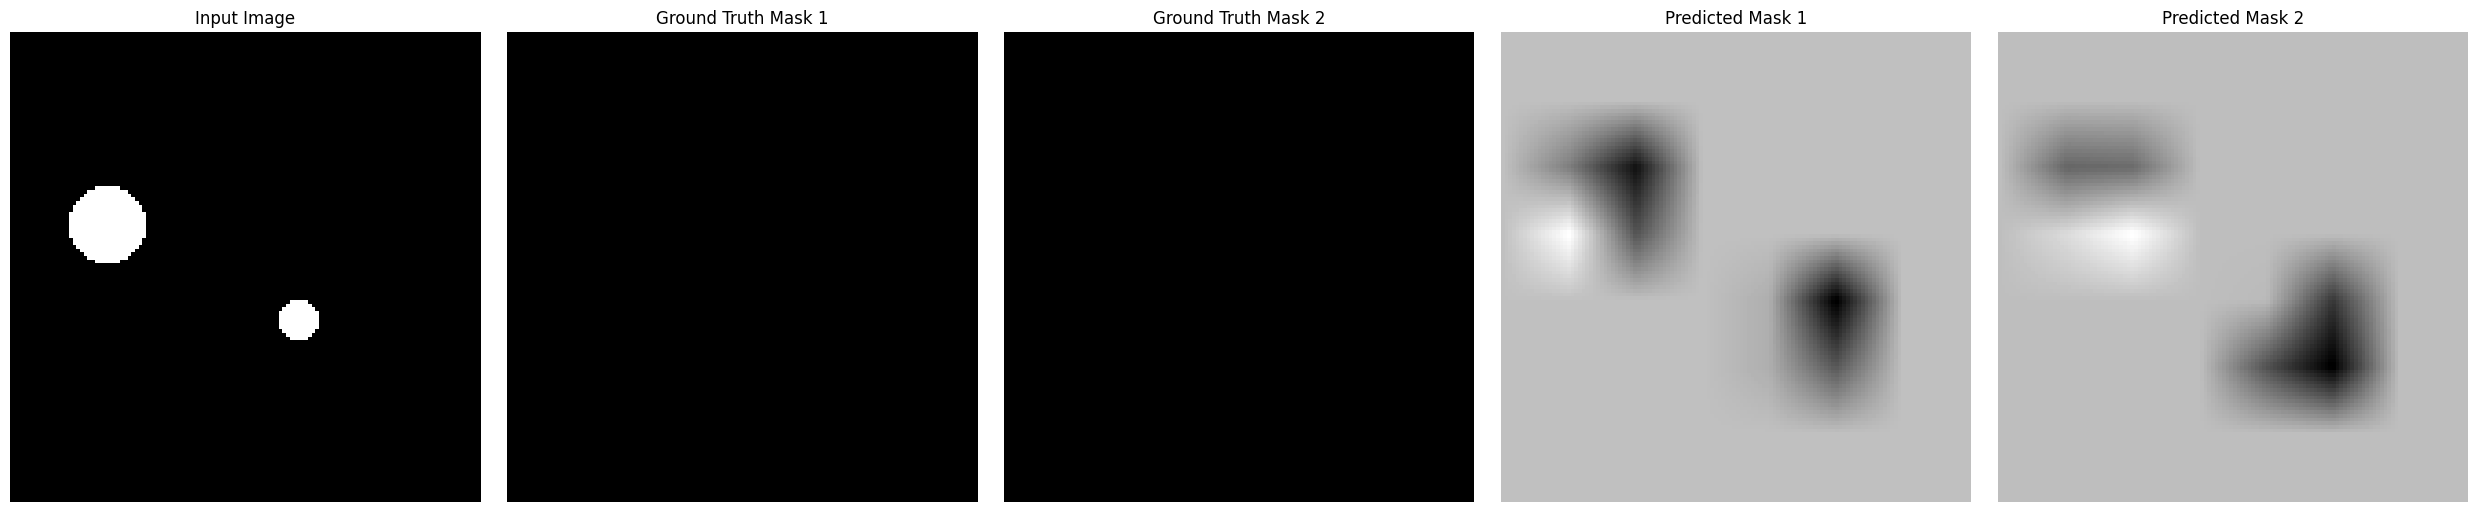

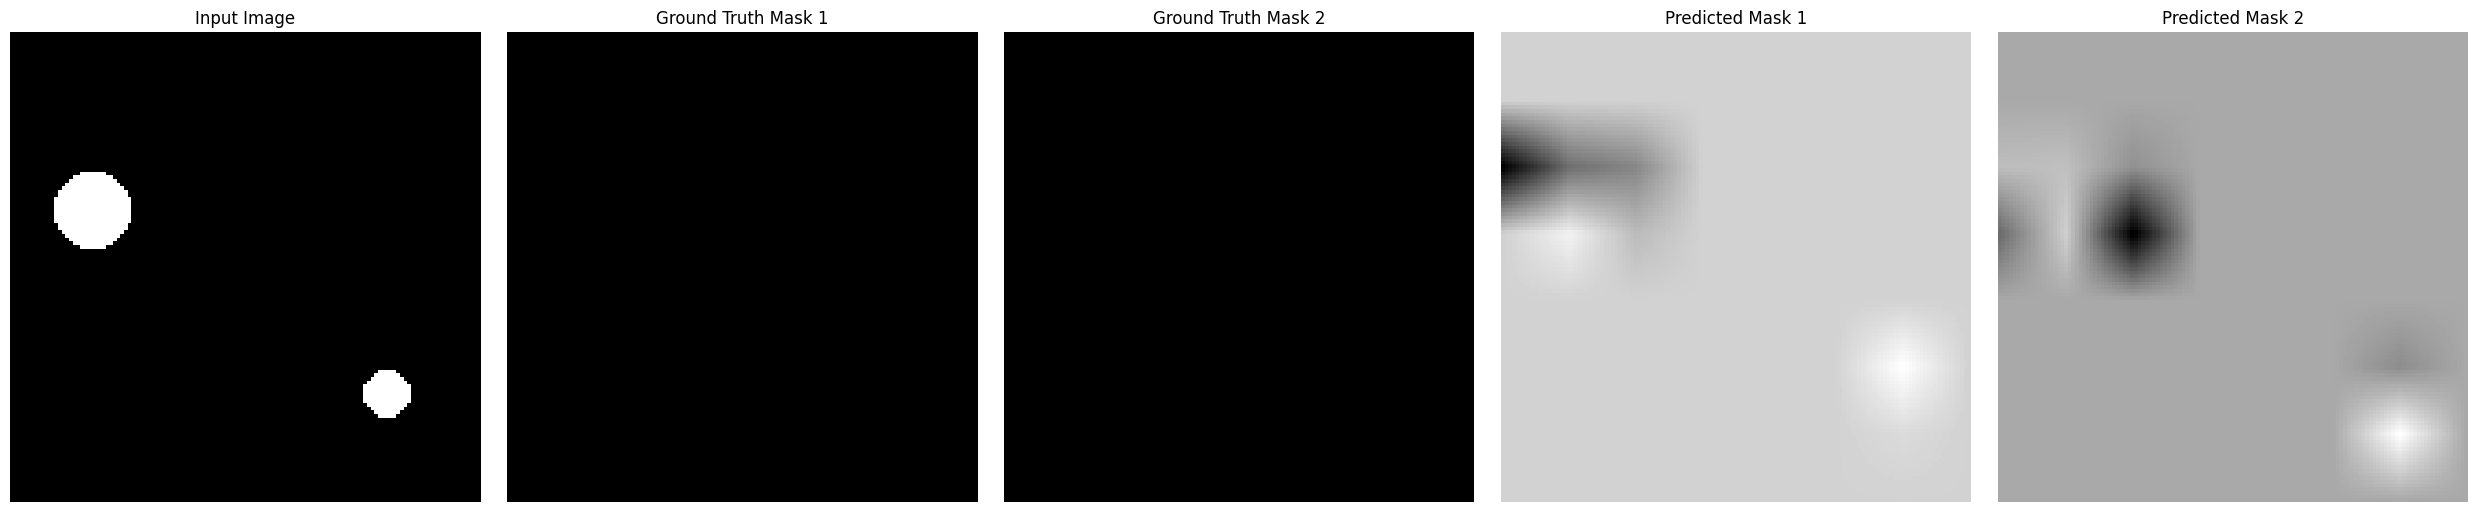

In [23]:
def plot_predictions(model, dataloader, device='cpu'):
    """
    Visualizes inputs, ground truth masks, and predicted masks from the model.
    
    Args:
        model: Trained PyTorch model for instance segmentation.
        dataloader: DataLoader with input images and ground truth masks.
        device: Device on which the model is running ('cpu' or 'cuda').
    """
    model.eval()  # Set the model to evaluation mode

    # Get a batch of data
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad():
        predictions = model(images)  # Forward pass through the model

    # Move tensors to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    batch_size = images.size(0)
    num_classes = predictions.size(1)

    # Plot each image in the batch
    for i in range(batch_size):
        num_ground_truth = masks.size(1)
        num_predicted = predictions.size(1)
        num_columns = 1 + num_ground_truth + num_predicted  # Total columns

        fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5))

        if num_columns == 1:
            axes = [axes]  # Ensure axes is iterable even for a single subplot

        # Input image
        axes[0].imshow(images[i].squeeze(), cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        # Ground truth masks
        for j in range(num_ground_truth):
            axes[1 + j].imshow(masks[i, j].squeeze(), cmap='gray')
            axes[1 + j].set_title(f'Ground Truth Mask {j+1}')
            axes[1 + j].axis('off')

        # Predicted masks
        for j in range(num_predicted):
            axes[1 + num_ground_truth + j].imshow(predictions[i, j].squeeze(), cmap='gray')
            axes[1 + num_ground_truth + j].set_title(f'Predicted Mask {j+1}')
            axes[1 + num_ground_truth + j].axis('off')

        plt.tight_layout()
        plt.show()

plot_predictions(model, dataloader)

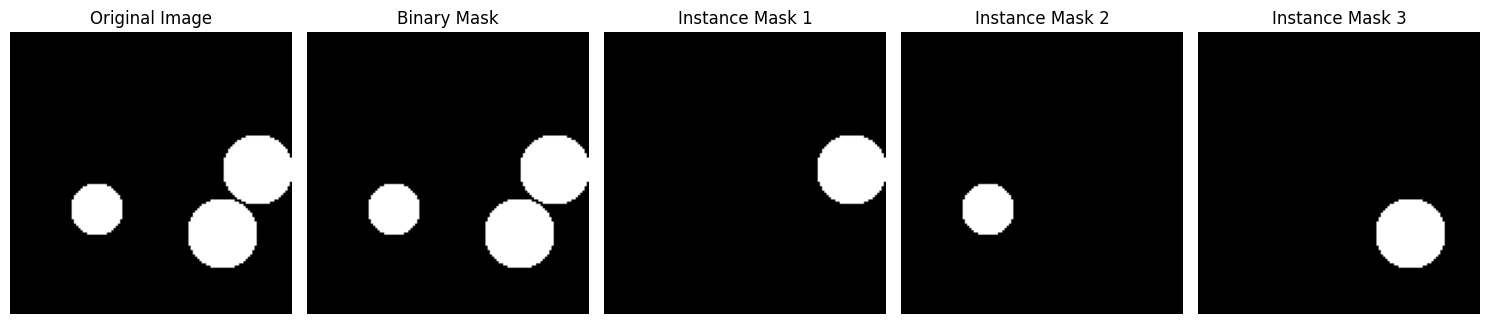

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.draw import disk
from skimage.measure import label, regionprops

def generate_image_with_circles(image_size=(128, 128), num_circles=1):
    """Generate an image with random circles and return the image and binary mask."""
    image = np.zeros(image_size, dtype=np.uint8)
    binary_mask = np.zeros(image_size, dtype=np.uint8)

    circle_centers = []
    circle_radii = []

    for _ in range(num_circles):
        radius = random.randint(10, 20)
        center = (
            random.randint(radius, image_size[0] - radius),
            random.randint(radius, image_size[1] - radius),
        )
        rr, cc = disk(center, radius, shape=image_size)
        image[rr, cc] = 255  # Circle in the image
        binary_mask[rr, cc] = 1  # Binary mask of the circle

        circle_centers.append(center)
        circle_radii.append(radius)

    return image, binary_mask, circle_centers, circle_radii

def generate_instance_masks(binary_mask):
    """Generate instance masks from a binary mask."""
    labeled_mask = label(binary_mask)
    instance_masks = []
    
    for region in regionprops(labeled_mask):
        instance_mask = labeled_mask == region.label
        instance_masks.append(instance_mask)

    return instance_masks

def visualize_results(image, binary_mask, instance_masks):
    """Visualize the image, binary mask, and instance masks."""
    fig, axes = plt.subplots(1, 2 + len(instance_masks), figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")

    for i, instance_mask in enumerate(instance_masks):
        axes[2 + i].imshow(instance_mask, cmap='gray')
        axes[2 + i].set_title(f"Instance Mask {i + 1}")
        axes[2 + i].axis("off")

    plt.tight_layout()
    plt.show()

# Generate a toy example
num_circles = random.randint(1, 3)
image, binary_mask, circle_centers, circle_radii = generate_image_with_circles(num_circles=num_circles)

# Generate instance masks
instance_masks = generate_instance_masks(binary_mask)

# Visualize the results
visualize_results(image, binary_mask, instance_masks)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.draw import disk
from skimage.measure import label, regionprops
import tensorflow as tf
from tensorflow.keras import layers, models

def generate_image_with_circles(image_size=(128, 128), num_circles=1):
    """Generate an image with random circles and return the image and binary mask."""
    image = np.zeros(image_size, dtype=np.uint8)
    binary_mask = np.zeros(image_size, dtype=np.uint8)

    circle_centers = []
    circle_radii = []

    for _ in range(num_circles):
        radius = random.randint(10, 20)
        center = (
            random.randint(radius, image_size[0] - radius),
            random.randint(radius, image_size[1] - radius),
        )
        rr, cc = disk(center, radius, shape=image_size)
        image[rr, cc] = 255  # Circle in the image
        binary_mask[rr, cc] = 1  # Binary mask of the circle

        circle_centers.append(center)
        circle_radii.append(radius)

    return image, binary_mask, circle_centers, circle_radii

def generate_instance_masks(binary_mask):
    """Generate instance masks from a binary mask."""
    labeled_mask = label(binary_mask)
    instance_masks = []
    
    for region in regionprops(labeled_mask):
        instance_mask = labeled_mask == region.label
        instance_masks.append(instance_mask)

    return instance_masks

def visualize_results(image, binary_mask, instance_masks):
    """Visualize the image, binary mask, and instance masks."""
    fig, axes = plt.subplots(1, 2 + len(instance_masks), figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")

    for i, instance_mask in enumerate(instance_masks):
        axes[2 + i].imshow(instance_mask, cmap='gray')
        axes[2 + i].set_title(f"Instance Mask {i + 1}")
        axes[2 + i].axis("off")

    plt.tight_layout()
    plt.show()

def create_dataset(num_samples=100, image_size=(128, 128), max_circles=3):
    """Create a dataset of binary masks and instance masks."""
    binary_masks = []
    instance_masks = []

    for _ in range(num_samples):
        num_circles = random.randint(1, max_circles)
        _, binary_mask, _, _ = generate_image_with_circles(image_size, num_circles)
        instances = generate_instance_masks(binary_mask)

        binary_masks.append(binary_mask)
        instance_stack = np.stack(instances, axis=-1) if instances else np.zeros((*image_size, 0))
        instance_masks.append(instance_stack)

    return np.array(binary_masks), instance_masks

def build_model(input_shape=(128, 128, 1), num_instances=3):
    """Build a simple U-Net-like model for instance segmentation."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D((2, 2))(conv3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D((2, 2))(conv4)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(num_instances, (1, 1), activation='sigmoid')(conv5)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate a dataset
num_samples = 100
binary_masks, instance_masks = create_dataset(num_samples=num_samples)

# Prepare the data
X = np.expand_dims(binary_masks, axis=-1)  # Add channel dimension
y = np.zeros((num_samples, 128, 128, 3))  # Limit to 3 instances

for i, instances in enumerate(instance_masks):
    for j in range(min(3, instances.shape[-1])):  # Ensure max 3 channels
        y[i, :, :, j] = instances[:, :, j]

# Build and train the model
model = build_model()
model.fit(X, y, epochs=10, batch_size=8)


2024-12-10 15:46:28.915717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 15:46:29.984572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733863590.413299 3896516 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733863590.478780 3896516 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 15:46:31.218736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

InternalError: cudaSetDevice() on GPU:0 failed. Status: CUDA-capable device(s) is/are busy or unavailable

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.draw import disk
from skimage.measure import label, regionprops
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CircleDataset(Dataset):
    def __init__(self, num_samples=100, image_size=(128, 128), max_circles=3):
        self.binary_masks, self.instance_masks = self.create_dataset(num_samples, image_size, max_circles)

    def __len__(self):
        return len(self.binary_masks)

    def __getitem__(self, idx):
        binary_mask = self.binary_masks[idx]
        instance_mask = self.instance_masks[idx]
        instance_mask = np.pad(instance_mask, ((0, 0), (0, 0), (0, 3 - instance_mask.shape[2])), constant_values=0)
        return torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0), torch.tensor(instance_mask, dtype=torch.float32)

    @staticmethod
    def create_dataset(num_samples=100, image_size=(128, 128), max_circles=3):
        binary_masks = []
        instance_masks = []

        for _ in range(num_samples):
            num_circles = random.randint(1, max_circles)
            _, binary_mask, _, _ = generate_image_with_circles(image_size, num_circles)
            instances = generate_instance_masks(binary_mask)

            binary_masks.append(binary_mask)
            instance_stack = np.stack(instances, axis=-1) if instances else np.zeros((*image_size, 0))
            instance_masks.append(instance_stack)

        return np.array(binary_masks), instance_masks

def generate_image_with_circles(image_size=(128, 128), num_circles=1):
    """Generate an image with random circles and return the image and binary mask."""
    image = np.zeros(image_size, dtype=np.uint8)
    binary_mask = np.zeros(image_size, dtype=np.uint8)

    for _ in range(num_circles):
        radius = random.randint(10, 20)
        center = (
            random.randint(radius, image_size[0] - radius),
            random.randint(radius, image_size[1] - radius),
        )
        rr, cc = disk(center, radius, shape=image_size)
        binary_mask[rr, cc] = 1

    return image, binary_mask, [], []

def generate_instance_masks(binary_mask):
    """Generate instance masks from a binary mask."""
    labeled_mask = label(binary_mask)
    instance_masks = []
    for region in regionprops(labeled_mask):
        instance_mask = labeled_mask == region.label
        instance_masks.append(instance_mask)
    return instance_masks

def visualize_results(image, binary_mask, instance_masks):
    """Visualize the image, binary mask, and instance masks."""
    fig, axes = plt.subplots(1, 2 + len(instance_masks), figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")

    for i, instance_mask in enumerate(instance_masks):
        axes[2 + i].imshow(instance_mask, cmap='gray')
        axes[2 + i].set_title(f"Instance Mask {i + 1}")
        axes[2 + i].axis("off")

    plt.tight_layout()
    plt.show()

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(in_channels, 32)
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)

        self.decoder1 = self.conv_block(128, 64)
        self.decoder2 = self.conv_block(64, 32)
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        d1 = self.up(e3)
        d1 = self.decoder1(d1 + e2)
        d2 = self.up(d1)
        d2 = self.decoder2(d2 + e1)

        return torch.sigmoid(self.final_conv(d2))

# Dataset and DataLoader
num_samples = 100
train_dataset = CircleDataset(num_samples=num_samples)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model, Loss, Optimizer
model = UNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for binary_mask, instance_masks in train_loader:
        optimizer.zero_grad()
        outputs = model(binary_mask)
        loss = criterion(outputs, instance_masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 1

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.draw import disk
from skimage.measure import label, regionprops
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CircleDataset(Dataset):
    def __init__(self, num_samples=100, image_size=(128, 128), max_circles=3):
        self.binary_masks, self.instance_masks = self.create_dataset(num_samples, image_size, max_circles)

    def __len__(self):
        return len(self.binary_masks)

    def __getitem__(self, idx):
        binary_mask = self.binary_masks[idx]
        instance_mask = self.instance_masks[idx]
        instance_mask = np.pad(instance_mask, ((0, 0), (0, 0), (0, 3 - instance_mask.shape[2])), constant_values=0)
        return torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0), torch.tensor(instance_mask, dtype=torch.float32)

    @staticmethod
    def create_dataset(num_samples=100, image_size=(128, 128), max_circles=3):
        binary_masks = []
        instance_masks = []

        for _ in range(num_samples):
            num_circles = random.randint(1, max_circles)
            _, binary_mask, _, _ = generate_image_with_circles(image_size, num_circles)
            instances = generate_instance_masks(binary_mask)

            binary_masks.append(binary_mask)
            instance_stack = np.stack(instances, axis=-1) if instances else np.zeros((*image_size, 0))
            instance_masks.append(instance_stack)

        return np.array(binary_masks), instance_masks

def generate_image_with_circles(image_size=(128, 128), num_circles=1):
    """Generate an image with random circles and return the image and binary mask."""
    image = np.zeros(image_size, dtype=np.uint8)
    binary_mask = np.zeros(image_size, dtype=np.uint8)

    for _ in range(num_circles):
        radius = random.randint(10, 20)
        center = (
            random.randint(radius, image_size[0] - radius),
            random.randint(radius, image_size[1] - radius),
        )
        rr, cc = disk(center, radius, shape=image_size)
        binary_mask[rr, cc] = 1

    return image, binary_mask, [], []

def generate_instance_masks(binary_mask):
    """Generate instance masks from a binary mask."""
    labeled_mask = label(binary_mask)
    instance_masks = []
    for region in regionprops(labeled_mask):
        instance_mask = labeled_mask == region.label
        instance_masks.append(instance_mask)
    return instance_masks

def visualize_results(image, binary_mask, instance_masks):
    """Visualize the image, binary mask, and instance masks."""
    fig, axes = plt.subplots(1, 2 + len(instance_masks), figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")

    for i, instance_mask in enumerate(instance_masks):
        axes[2 + i].imshow(instance_mask, cmap='gray')
        axes[2 + i].set_title(f"Instance Mask {i + 1}")
        axes[2 + i].axis("off")

    plt.tight_layout()
    plt.show()

def resize_to_match(x, target):
    """Resize tensor `x` to match the size of `target` by cropping or padding."""
    diff_y = target.size(2) - x.size(2)
    diff_x = target.size(3) - x.size(3)

    x = nn.functional.pad(x, [
        diff_x // 2, diff_x - diff_x // 2,
        diff_y // 2, diff_y - diff_y // 2
    ])
    return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(in_channels, 32)
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)

        self.decoder1 = self.conv_block(128, 64)
        self.decoder2 = self.conv_block(64, 32)
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        d1 = self.up(e3)
        d1 = self.decoder1(resize_to_match(d1, e2) + e2)
        d2 = self.up(d1)
        d2 = self.decoder2(resize_to_match(d2, e1) + e1)

        return torch.sigmoid(self.final_conv(d2))

# Dataset and DataLoader
num_samples = 100
train_dataset = CircleDataset(num_samples=num_samples)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model, Loss, Optimizer
model = UNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for binary_mask, instance_masks in train_loader:
        optimizer.zero_grad()
        outputs = model(binary_mask)
        loss = criterion(outputs, instance_masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 1

/usr4/ec523/ipboyd/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/1000], Loss: 0.3823


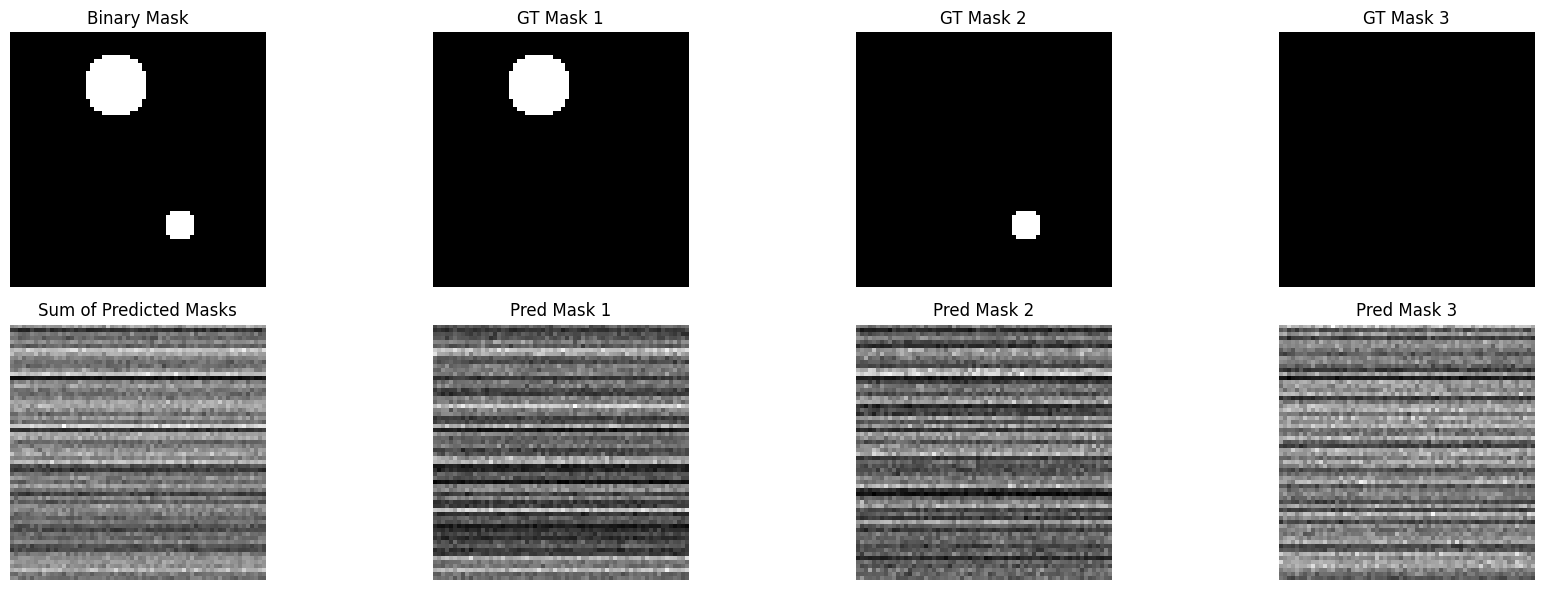

Epoch [101/1000], Loss: 0.0834


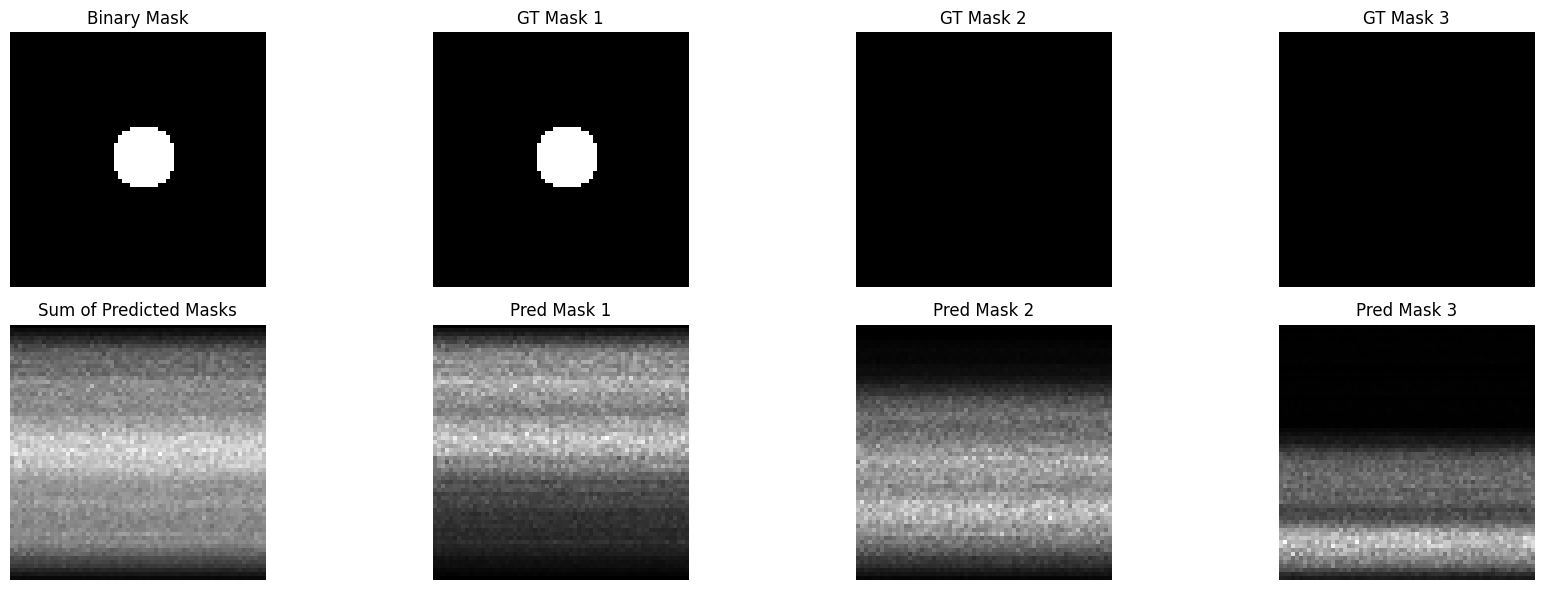

Epoch [201/1000], Loss: 0.0827


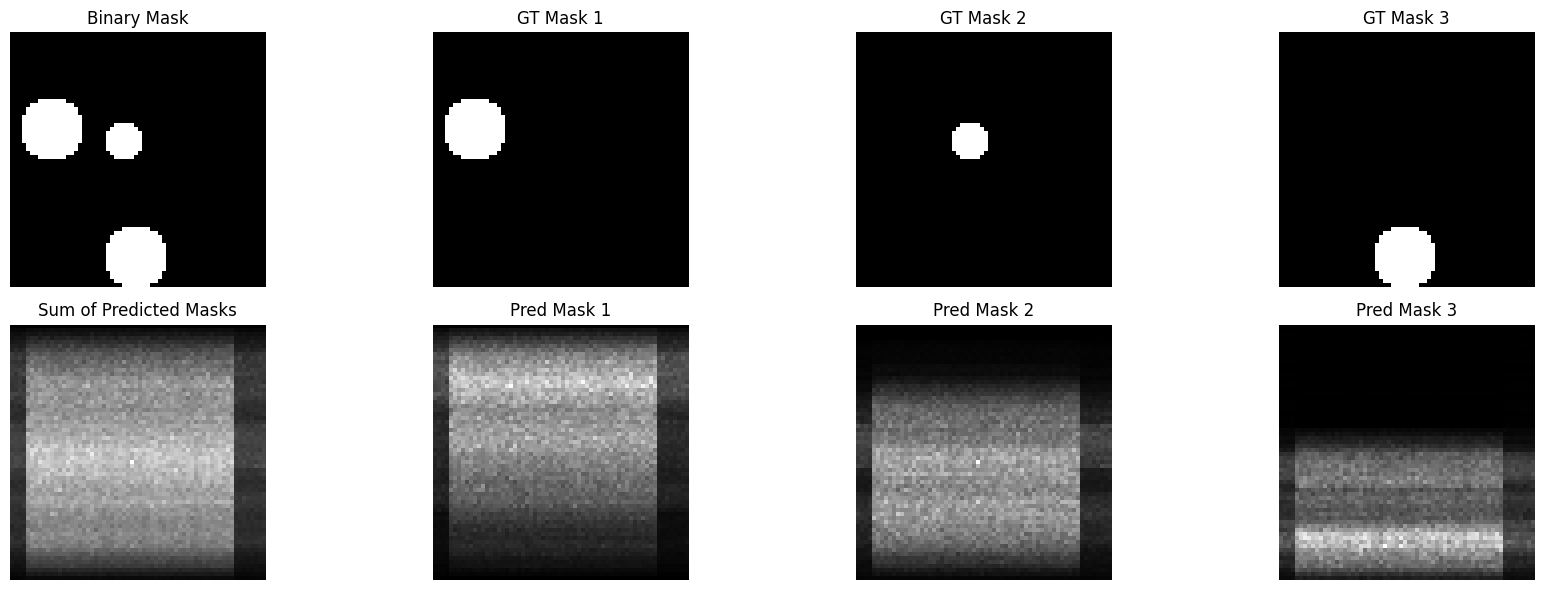

Epoch [301/1000], Loss: 0.0826


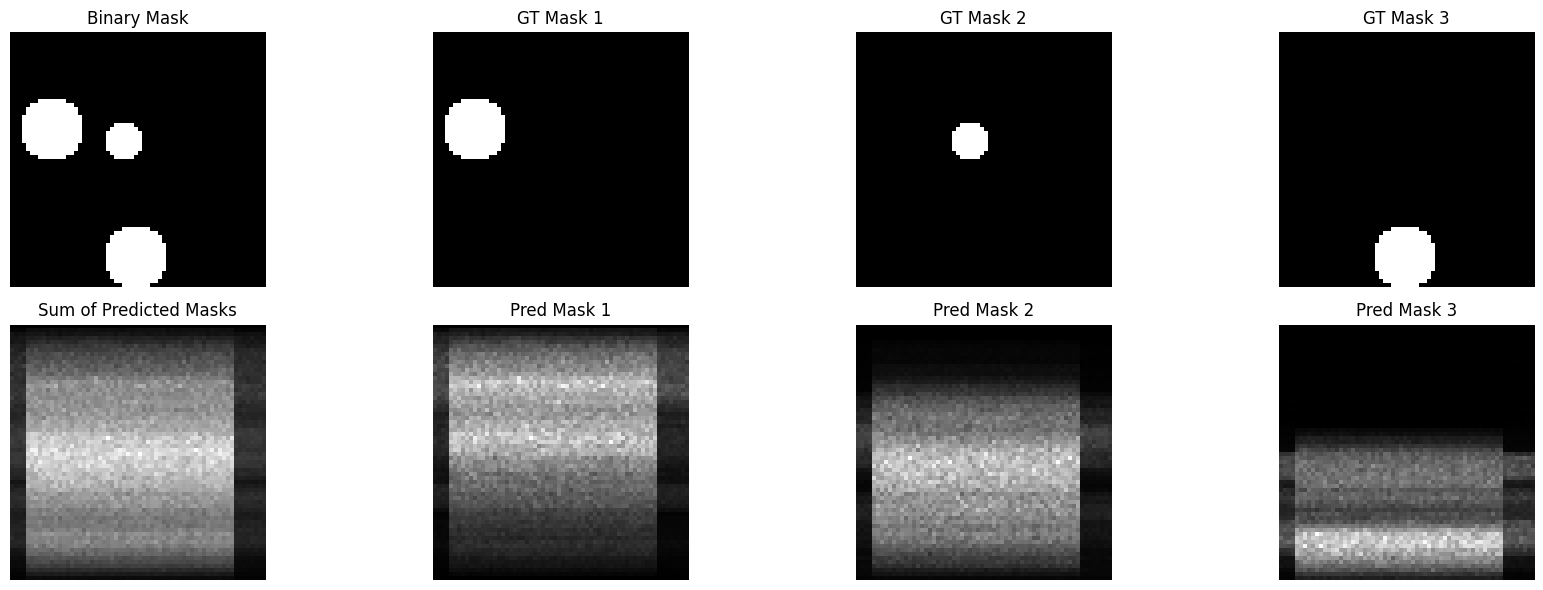

Epoch [401/1000], Loss: 0.0840


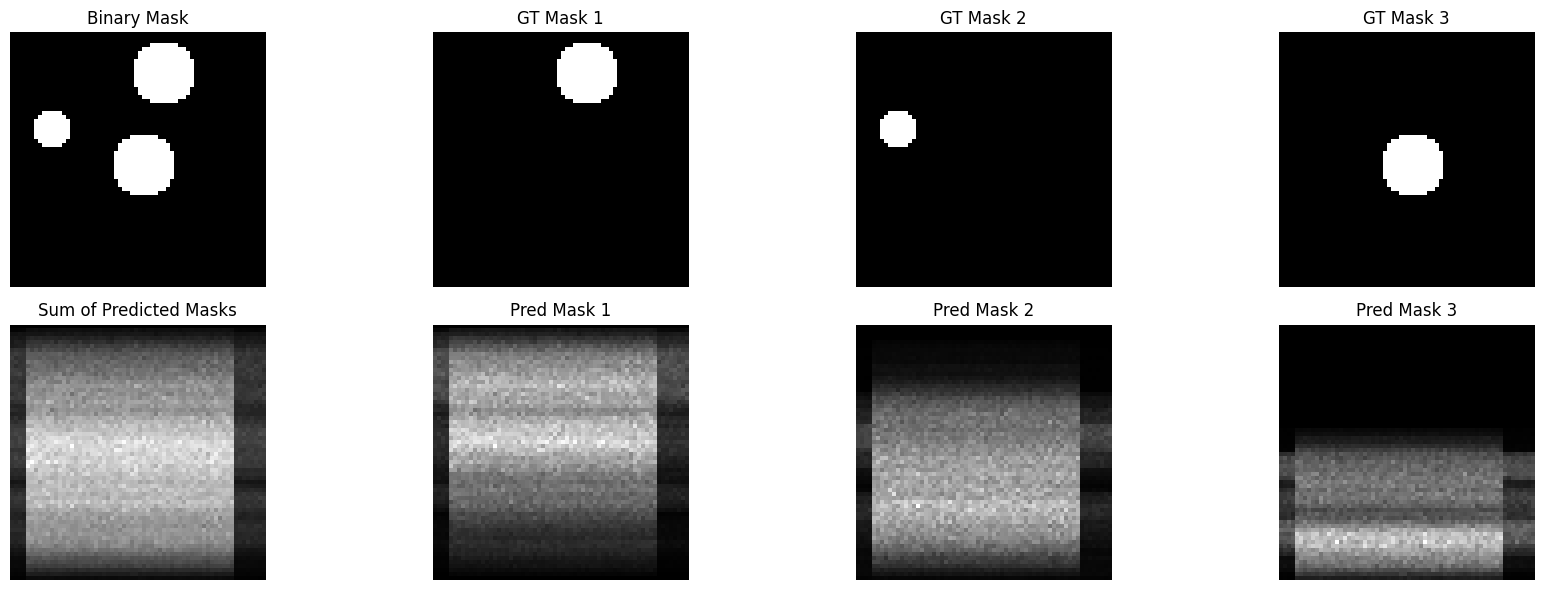

Epoch [501/1000], Loss: 0.0826


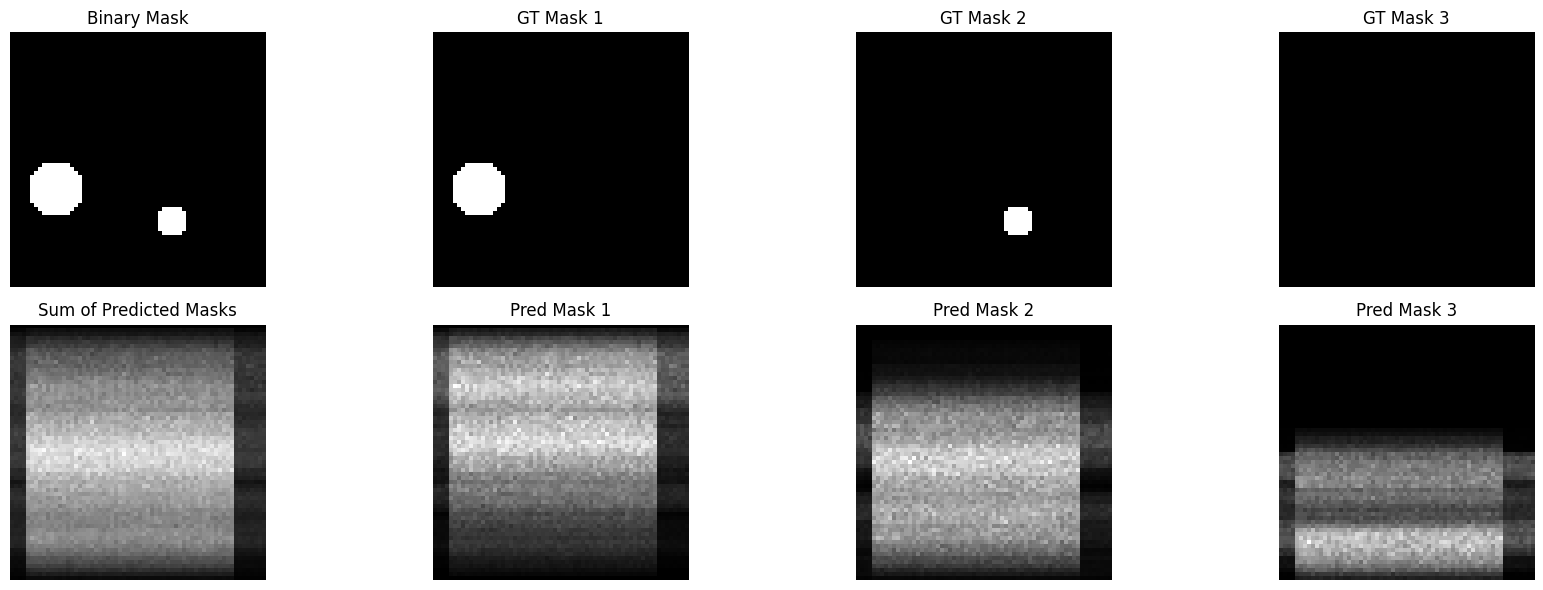

Epoch [601/1000], Loss: 0.0825


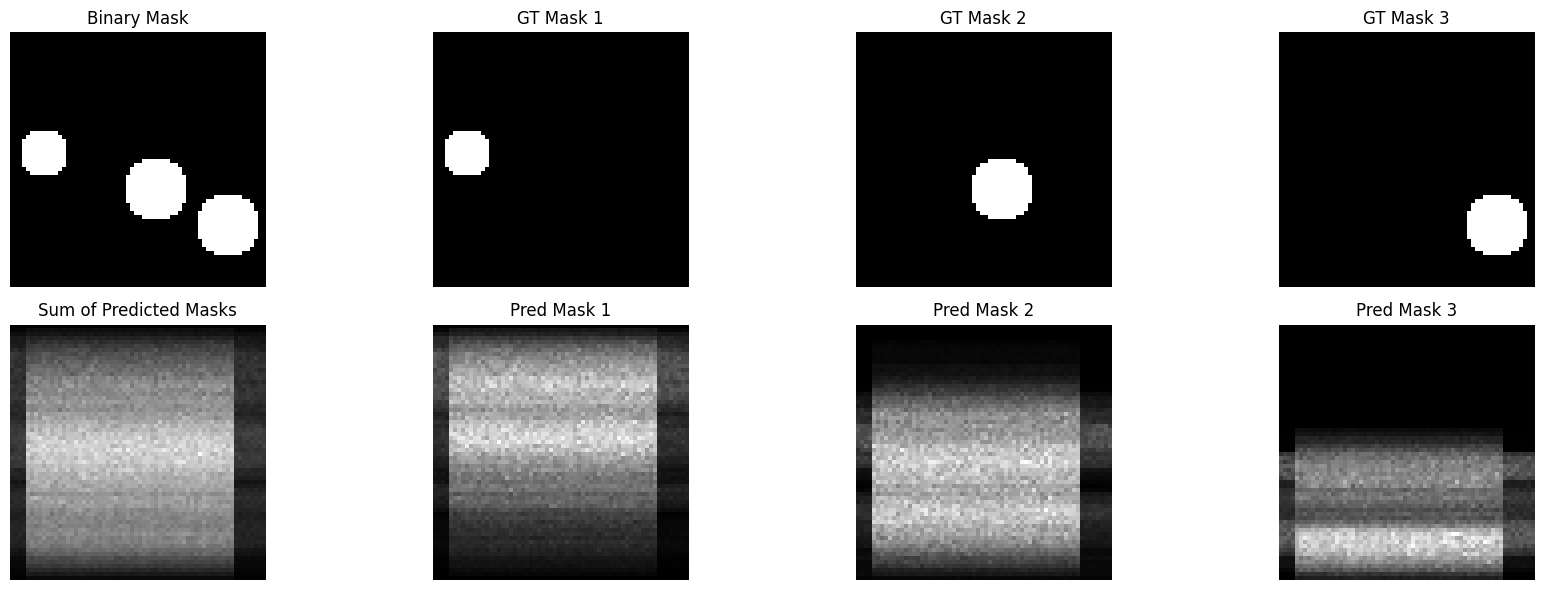

Epoch [701/1000], Loss: 0.0819


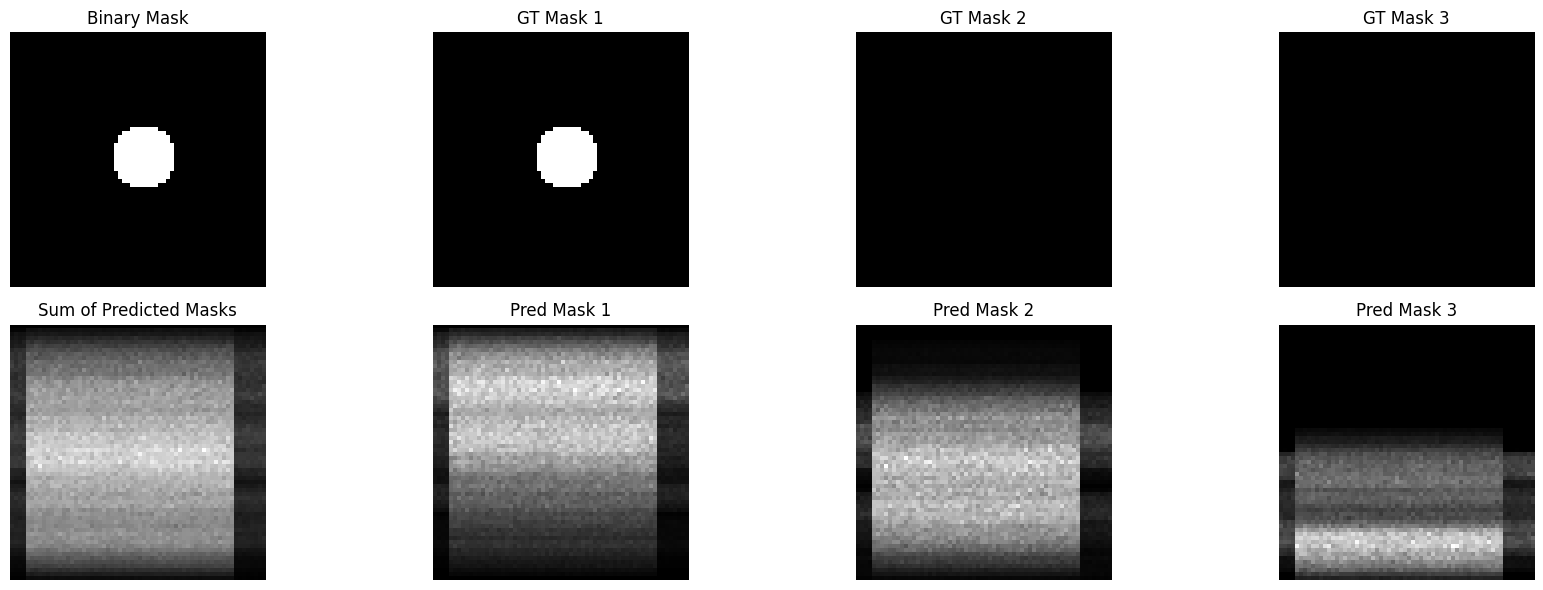

Epoch [801/1000], Loss: 0.0827


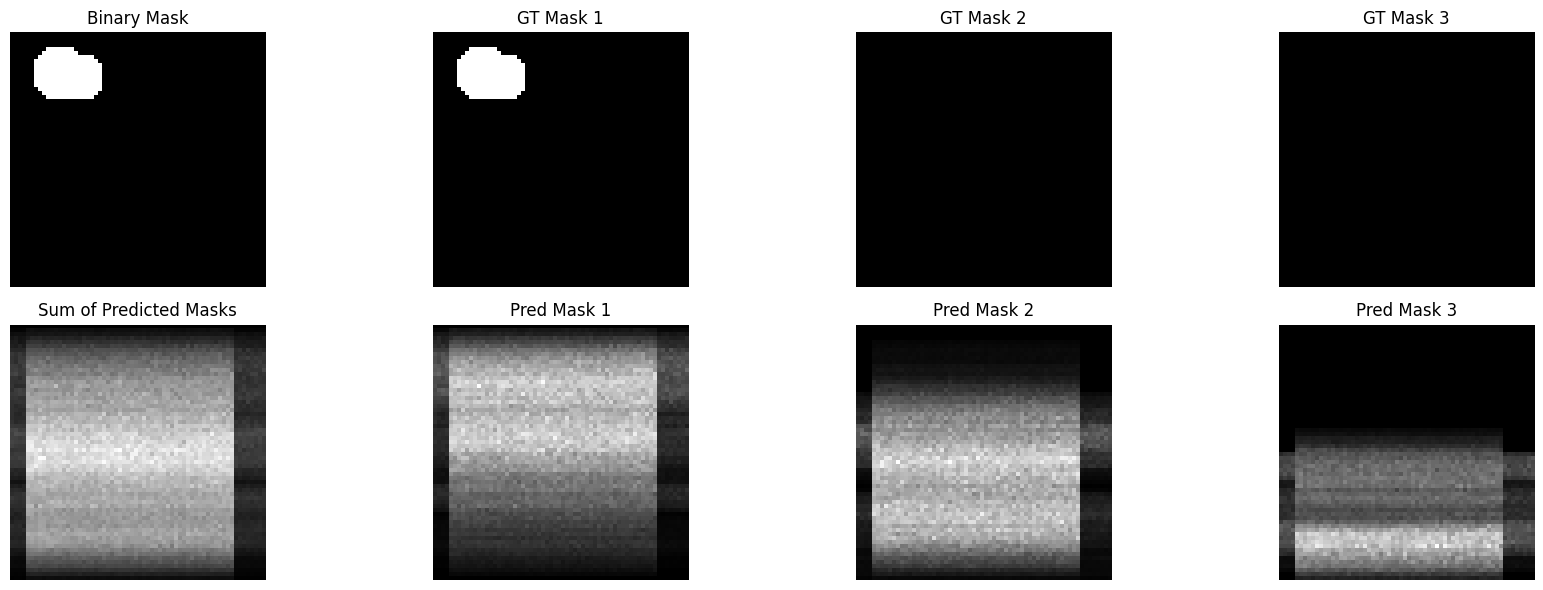

Epoch [901/1000], Loss: 0.0824


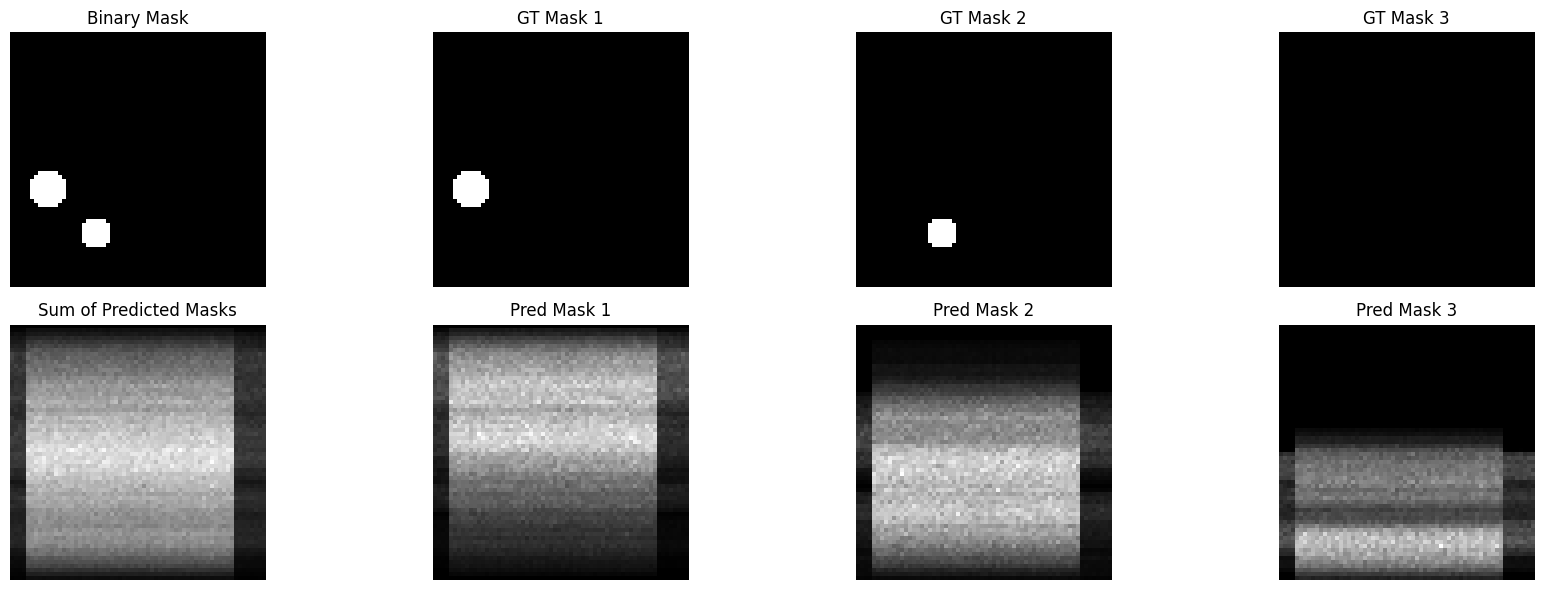

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.draw import disk
from skimage.measure import label, regionprops
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



class CircleDataset(Dataset):
    def __init__(self, num_samples=100, image_size=(64, 64), max_circles=3):
        self.binary_masks, self.instance_masks = self.create_dataset(num_samples, image_size, max_circles)

    def __len__(self):
        return len(self.binary_masks)

    def __getitem__(self, idx):
        binary_mask = self.binary_masks[idx]
        instance_mask = self.instance_masks[idx]
        instance_mask = np.pad(instance_mask, ((0, 0), (0, 0), (0, 3 - instance_mask.shape[2])), constant_values=0)
        return torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0), torch.tensor(instance_mask, dtype=torch.float32)

    @staticmethod
    def create_dataset(num_samples=100, image_size=(64, 64), max_circles=3):
        binary_masks = []
        instance_masks = []

        for _ in range(num_samples):
            num_circles = random.randint(1, max_circles)
            _, binary_mask, _, _ = generate_image_with_circles(image_size, num_circles)
            instances = generate_instance_masks(binary_mask)

            binary_masks.append(binary_mask)
            instance_stack = np.stack(instances, axis=-1) if instances else np.zeros((*image_size, 0))
            instance_masks.append(instance_stack)

        return np.array(binary_masks), instance_masks

def generate_image_with_circles(image_size=(64, 64), num_circles=1):
    """Generate an image with random circles and return the image and binary mask."""
    image = np.zeros(image_size, dtype=np.uint8)
    binary_mask = np.zeros(image_size, dtype=np.uint8)

    for _ in range(num_circles):
        radius = random.randint(4, 8)
        center = (
            random.randint(radius, image_size[0] - radius),
            random.randint(radius, image_size[1] - radius),
        )
        rr, cc = disk(center, radius, shape=image_size)
        binary_mask[rr, cc] = 1

    return image, binary_mask, [], []

def generate_instance_masks(binary_mask):
    """Generate instance masks from a binary mask."""
    labeled_mask = label(binary_mask)
    instance_masks = []
    for region in regionprops(labeled_mask):
        instance_mask = labeled_mask == region.label
        instance_masks.append(instance_mask)
    return instance_masks

def visualize_results(image, binary_mask, instance_masks):
    """Visualize the image, binary mask, and instance masks."""
    fig, axes = plt.subplots(1, 2 + len(instance_masks), figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")

    for i, instance_mask in enumerate(instance_masks):
        axes[2 + i].imshow(instance_mask, cmap='gray')
        axes[2 + i].set_title(f"Instance Mask {i + 1}")
        axes[2 + i].axis("off")

    plt.tight_layout()
    plt.show()

class TransformerSegmentationModel(nn.Module):   # 8,64   # 4,256
    def __init__(self, img_size=64, patch_size=8, num_patches=64, in_channels=1, out_channels=3, embed_dim=640, num_heads=8, num_layers=12):
        super(TransformerSegmentationModel, self).__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.flatten_dim = patch_size * patch_size * in_channels
        self.out_channels = out_channels

        self.embedding = nn.Linear(self.flatten_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output_proj = nn.Linear(embed_dim, patch_size * patch_size * out_channels)

    def forward(self, x):
        batch_size = x.size(0)
        
        #print('forwards pass')
        #print(x.shape)

        # Divide image into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(batch_size, self.num_patches, -1)
        
        #print(x.shape)

        # Embedding and positional encoding
        x = self.embedding(x) + self.position_embedding

        # Transformer
        x = self.transformer(x)
        
        #print(x.shape)

        # Output projection and reshape
        x = self.output_proj(x)
        #x = x.view(batch_size, self.img_size // self.patch_size, self.img_size // self.patch_size, -1)
        
        #print(x.shape)

        
        x = x.view(batch_size,self.img_size,self.out_channels,self.img_size)
        
        x = x.permute(0, 3, 1, 2).contiguous()
        
        #print(x.shape)

        return torch.sigmoid(x)

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Dataset and DataLoader
num_samples = 100
train_dataset = CircleDataset(num_samples=num_samples)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model, Loss, Optimizer
model = TransformerSegmentationModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for binary_mask, instance_masks in train_loader:
        optimizer.zero_grad()
        
        binary_mask = binary_mask.to(device)  # Move binary_mask to device
        instance_masks = instance_masks.to(device) 
        
        outputs = model(binary_mask)
        
        #print('outputs')
        #print(outputs.shape)
        #print(instance_masks.shape)
        
        loss = criterion(outputs, instance_masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    
    if epoch % 100 == 0:
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")
        
        with torch.no_grad():

            
            # Visualizing the binary mask
            binary_mask = binary_mask[0].squeeze(0).cpu().numpy()
            instance_masks = instance_masks[0].cpu().numpy()
            predicted_masks = outputs[0].cpu().numpy()

            fig, axes = plt.subplots(2, max(instance_masks.shape[-1], predicted_masks.shape[-1]) + 1, figsize=(18, 6))

            # Binary Mask
            axes[0, 0].imshow(binary_mask, cmap='gray')
            axes[0, 0].set_title("Binary Mask")
            axes[0, 0].axis("off")

            # Ground Truth Masks
            for i in range(instance_masks.shape[-1]):
                axes[0, i + 1].imshow(instance_masks[..., i], cmap='gray')
                axes[0, i + 1].set_title(f"GT Mask {i+1}")
                axes[0, i + 1].axis("off")

            # Predicted Masks
            for i in range(predicted_masks.shape[-1]):
                axes[1, i + 1].imshow(predicted_masks[..., i], cmap='gray')
                axes[1, i + 1].set_title(f"Pred Mask {i+1}")
                axes[1, i + 1].axis("off")

            # Sum of Predicted Masks
            predicted_sum = np.sum(predicted_masks, axis=-1)
            axes[1, 0].imshow(predicted_sum, cmap='gray')
            axes[1, 0].set_title("Sum of Predicted Masks")
            axes[1, 0].axis("off")

            # Layout adjustment
            plt.tight_layout()
            plt.show()


In [ ]:
print('hi')